# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

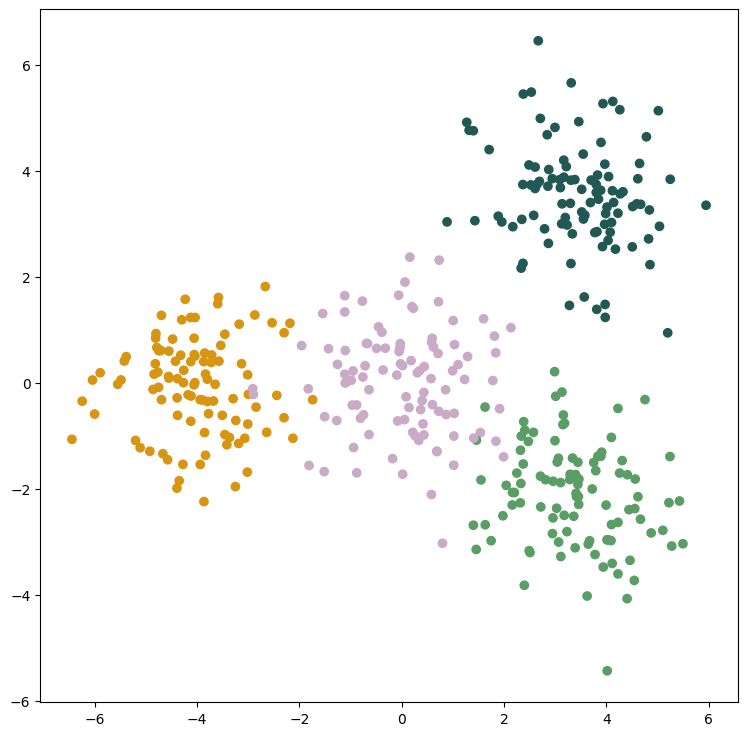

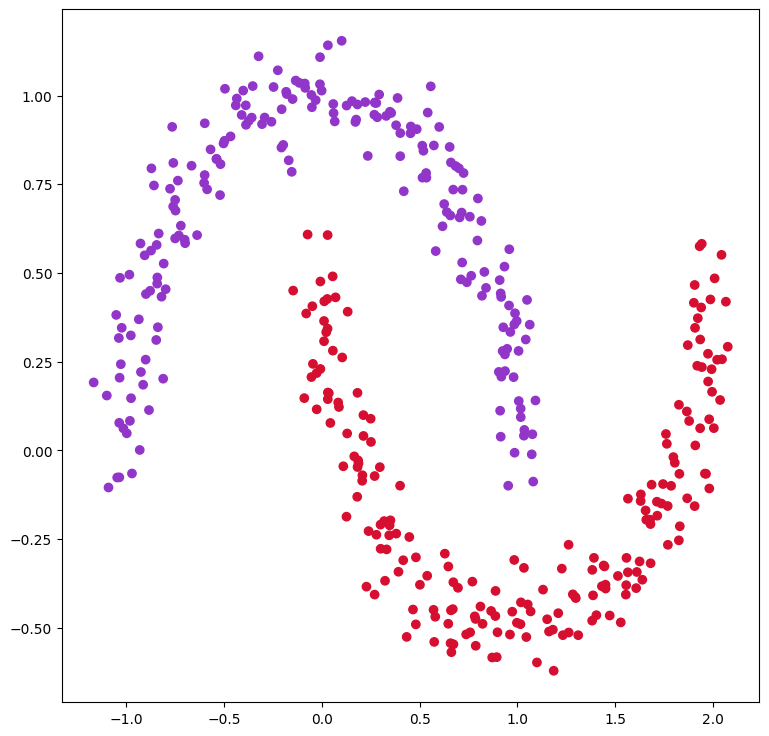

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [4]:
from task import KMeans

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

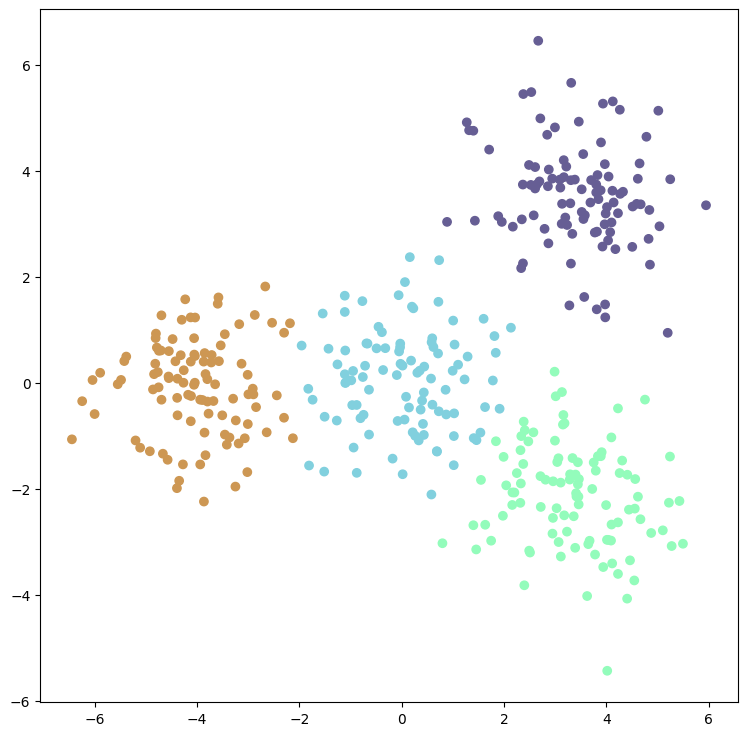

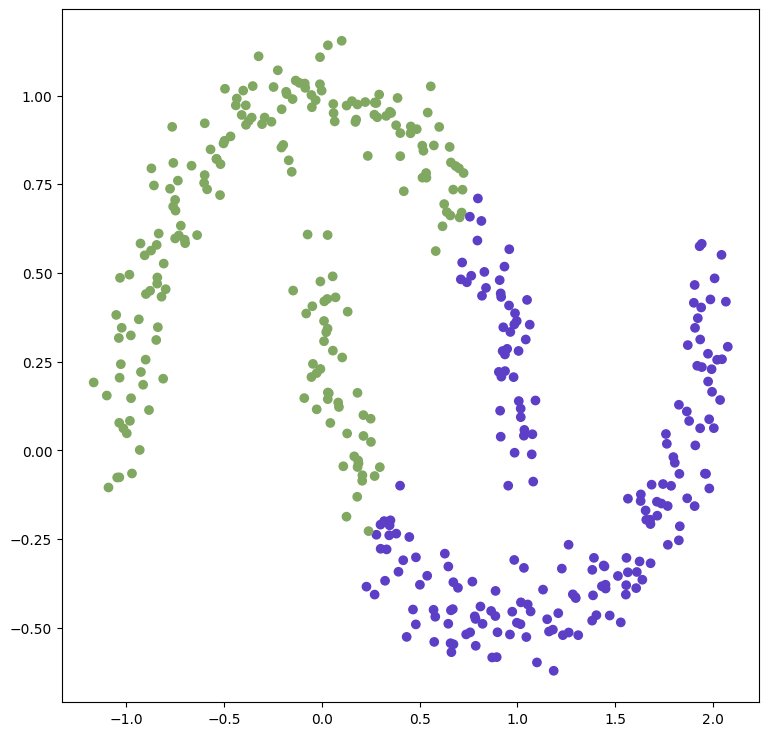

In [5]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="sample")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (3 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [6]:
from task import DBScan

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

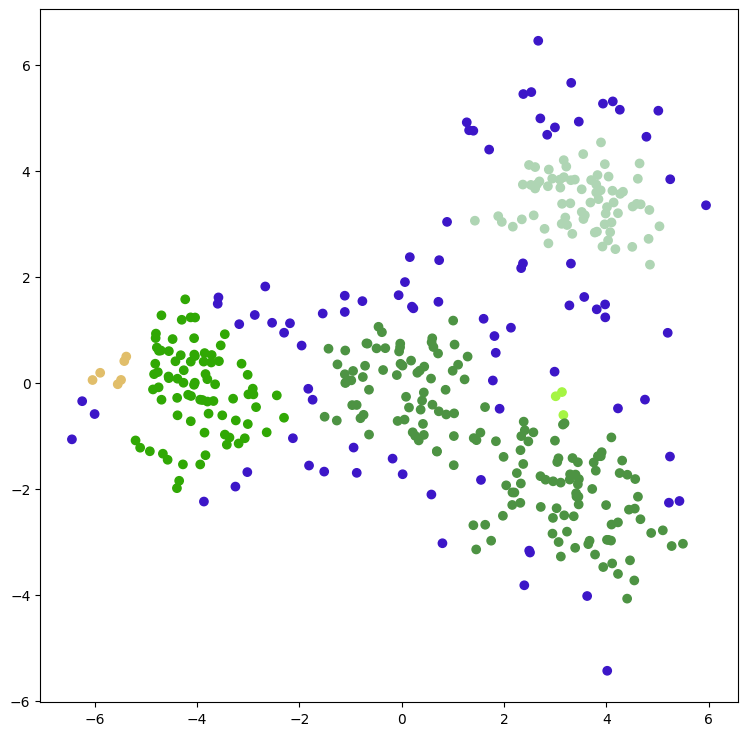

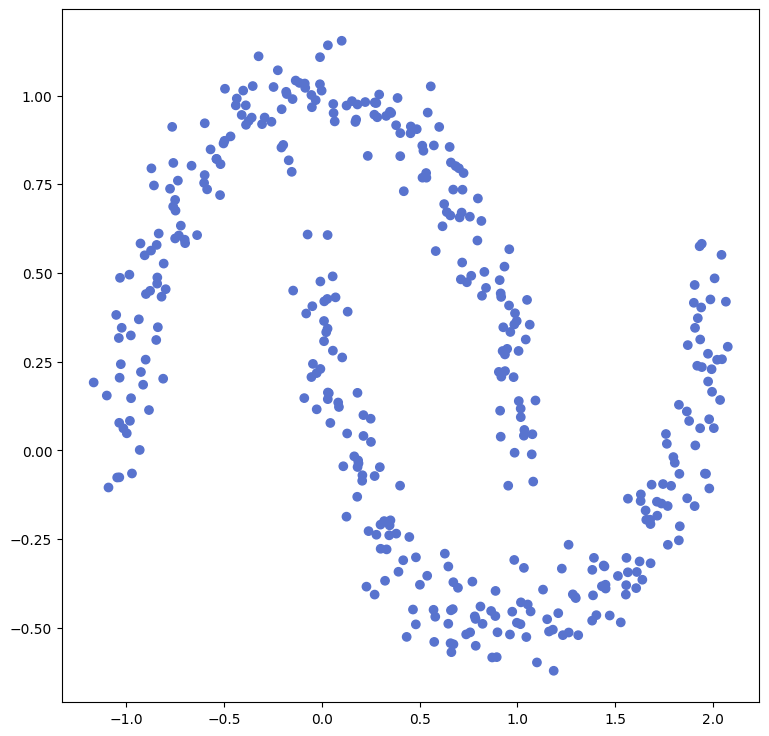

In [7]:
dbscan = DBScan()
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan()
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [8]:
from task import AgglomerativeClustering

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

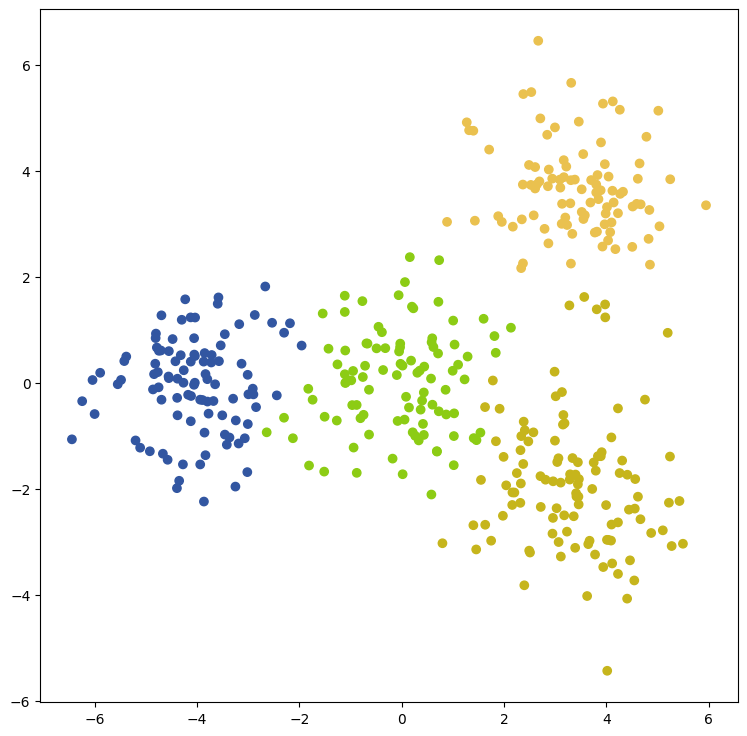

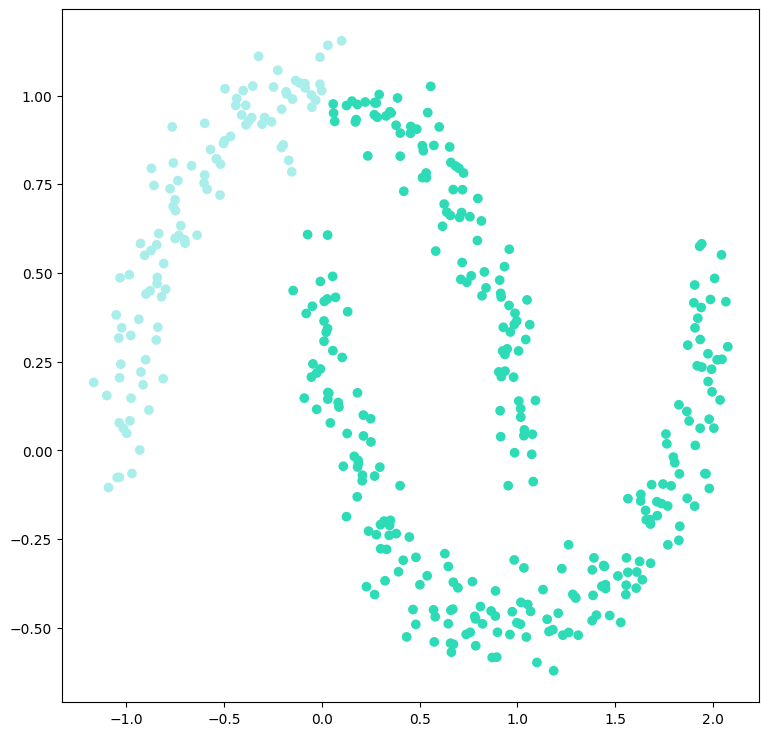

In [9]:
agg_clustering = AgglomerativeClustering(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="average")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Дополнительно
Научимся кластеризовать цвета в изображении. Для начала используем OpenCV для того, чтобы считать изображение.

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [10]:
def read_image(path: str) -> np.array:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) / 255.
    return image

def show_image(image: np.array) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    image = cv2.cvtColor(np.float32(image * 255), cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, image)

In [11]:
show_image(read_image("./image.png"))

[ WARN:0@1.194] global loadsave.cpp:248 findDecoder imread_('./image.png'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


Теперь реализуем функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем применим ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, n_clusters=8, color_scheme="rgb", show_cluster_statisitcs = False):
    orig_image = image
    if color_scheme == "hsv":
        image = cv2.cvtColor((image * 255).astype('float32'), cv2.COLOR_RGB2HSV)
        image /= 255.
    shape = image.shape
    
    small = image[::4,::4,:]
    image = image.reshape((-1, shape[-1]))
    orig_image = orig_image.reshape((-1, shape[-1]))
    X = small.reshape((-1, shape[-1]))
    kmeans = KMeans(max_iter=16, n_clusters=n_clusters, init="k-means++")
    kmeans.fit(X)
    clusters = kmeans.predict(image)
    cluster_colors = kmeans.centorids

    recolored = np.array([cluster_colors[c] for c in clusters]).reshape(shape)
    if color_scheme == "hsv":
        recolored *= 255
        recolored = cv2.cvtColor(recolored.astype('float32'), cv2.COLOR_HSV2RGB) / 255.
    if show_cluster_statisitcs:
        clusters_statistics(orig_image, cluster_colors, clusters)
    return recolored.reshape(shape)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=4)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=8)
show_image(result)

In [ ]:
image = read_image("./img.jpg")
result = clusterize_image(image, n_clusters=16)
show_image(result)